<a href="https://colab.research.google.com/github/GMobinit/cat_dog_recognition_model/blob/VGG_model/cat_dog_recognition_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

--2025-10-30 14:15:36--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 72.247.96.197, 2600:1406:5400:2ae::317f, 2600:1406:5400:2ac::317f
Connecting to download.microsoft.com (download.microsoft.com)|72.247.96.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  43.6MB/s    in 10s     

2025-10-30 14:15:46 (78.0 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
import tensorflow as tf
import zipfile

In [4]:
zipfile.ZipFile('kagglecatsanddogs_5340.zip', 'r').extractall('dataset')

In [5]:
import pathlib
data_dir = pathlib.Path('dataset/PetImages').with_suffix('')

In [6]:
cat_image_count = len(list(data_dir.glob('Cat/*.jpg')))
dog_image_count = len(list(data_dir.glob('Dog/*.jpg')))
print(f"cat image count: {cat_image_count}, dog image count: {dog_image_count}, all images: {cat_image_count+dog_image_count}")

cat image count: 12500, dog image count: 12500, all images: 25000


In [7]:
import PIL

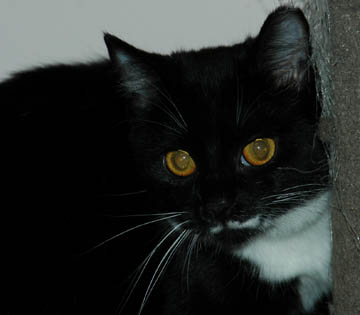

In [8]:
PIL.Image.open(str(list(data_dir.glob('Cat/910.jpg'))[0]))

In [9]:
list_ds  = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(cat_image_count+dog_image_count, reshuffle_each_iteration=False)
print(len(list_ds))

25000


In [10]:
for file_add in list_ds.take(5):
  print(file_add)

tf.Tensor(b'dataset/PetImages/Cat/8663.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Cat/5529.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Dog/842.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Dog/4135.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Cat/6198.jpg', shape=(), dtype=string)


In [11]:
labels = []
for item in data_dir.glob('*'):
  labels.append(item.name)

print(labels)

['Cat', 'Dog']


In [12]:
## train validation split
validation_percentage = 0.2
validation_size = int((cat_image_count+dog_image_count)*validation_percentage)
print(validation_size)
print(len(list_ds))
validation_ds = list_ds.take(validation_size)
train_ds = list_ds.skip(validation_size)

print(f'validation size {len(validation_ds)}, train size {len(train_ds)}')

5000
25000
validation size 5000, train size 20000


In [13]:
import os
def get_label(file_path):
  separated_path = tf.strings.split(file_path, os.path.sep)
  label = separated_path[-2]
  one_hotted_label = (label == labels)
  return tf.argmax(one_hotted_label)

In [14]:
get_label('dataset/kagglecatsanddogs_3367a/PetImages/Cat/7411.jpg')

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
def decode_img(encoded_img):
  img = tf.io.decode_jpeg(encoded_img, channels=3)
  img = tf.image.resize(img, [img_height, img_width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img

In [17]:
def process_path(img_path):
  label = get_label(img_path)
  img = tf.io.read_file(img_path)
  if tf.equal(tf.strings.length(img), 0):
    print("warning: empty file at ", img)
  try:
    img = decode_img(img)
  except Exception as e:
    print(f"wrong image format {img_path}")
  img = tf.cast(img, tf.float32)
  # img = ((img/255))
  return img, label

In [19]:
process_path('dataset/PetImages/Cat/910.jpg')

wrong image format dataset/PetImages/Cat/910.jpg


UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to float is not supported [Op:Cast] name: 

In [80]:
def is_valid_image(img_path):
  def check_image(path):
    try:
      # Decode path from bytes to string
      path_str = path.numpy().decode('utf-8') if isinstance(path, tf.Tensor) else path
      img = tf.io.read_file(path_str)
      decoded_img = tf.io.decode_jpeg(img, channels=3)
      # Check if we got a valid 3-channel image
      if decoded_img.shape[-1] == 3 and tf.size(decoded_img) > 0:
        return tf.equal(0,0)
      return tf.equal(1,0)
    except Exception as e:
      tf.print(f"Invalid image: {path_str}, Error: {e}")
      return tf.equal(1,0)

    result = tf.py_function(check_image, [img_path], tf.bool)
    print(result)
    result.set_shape([])
    return result

In [81]:
AUTOTUNE = tf.data.AUTOTUNE

# Filter out images that cause decoding errors
# def is_valid_image(img_path):
#   img = tf.io.read_file(img_path)
#   if tf.not_equal(tf.strings.length(img), 0):
#     try:
#       decoded_img = tf.io.decode_jpeg(img, channels=3)
#       # Check if the image has 3 channels (RGB)
#       return tf.equal(tf.shape(decoded_img)[-1], 3)
#     except Exception as e:
#       # Catching exceptions within tf.data.Dataset.filter is not ideal for performance
#       # but is used here for debugging purposes to identify problematic files.
#       # In a production pipeline, it's better to handle this differently, e.g.,
#       # by using tf.debugging.assert_equal and then filtering based on the assertion.
#       tf.print(f"Invalid image: {img_path}")
#       return False
#   else:
#     tf.print(f"Empty image: {img_path}")
#     return False

filtered_train_ds = train_ds.filter(is_valid_image)
filtered_validation_ds = validation_ds.filter(is_valid_image)

mapped_train_ds = filtered_train_ds.map(map_func= process_path,num_parallel_calls=AUTOTUNE)
mapped_validation_ds = filtered_validation_ds.map(map_func=process_path, num_parallel_calls=AUTOTUNE)

# Add checks to see the size of the datasets after filtering
print(f"Size of filtered_train_ds after filtering: {tf.data.experimental.cardinality(filtered_train_ds).numpy()}")
print(f"Size of mapped_train_ds after filtering: {tf.data.experimental.cardinality(mapped_train_ds).numpy()}")
print(f"Size of mapped_validation_ds after filtering: {tf.data.experimental.cardinality(mapped_validation_ds).numpy()}")

ValueError: Invalid `predicate`. `predicate` must return a `tf.bool` scalar tensor, but its return type is NoneTensorSpec().

In [27]:
for item in mapped_train_ds.take(5):
  print("Image shape: ", item)
  # print("Image label: ", label.numpy())
# for image, label in mapped_train_ds:
#   print(image.numpy().shape)
#   if image.numpy().shape[-1] != 3:
#     print(image.numpy())

In [ ]:
def configure_for_performance(ds: tf.data.Dataset):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=500)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
high_performance_train_ds = configure_for_performance(mapped_train_ds)
high_performance_validation_ds = configure_for_performance(mapped_validation_ds)

In [ ]:
for a,b in high_performance_train_ds.take(1):
  print(a.shape)
  print(b.numpy())

In [ ]:
import matplotlib.pyplot as plt

for image_batch, label_batch in high_performance_train_ds.take(1):

  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint32"))
    label = label_batch[i]
    plt.title(labels[label])
    plt.axis("off")

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(180,180,3))

In [ ]:
base_model.trainable = False

In [ ]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
model = tf.keras.models.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = tf.keras.losses.BinaryCrossentropy, metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
model.fit(high_performance_train_ds, epochs=100, validation_data=high_performance_validation_ds)